In [1]:

import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict
from copy import deepcopy
from enum import Enum
from evo.core.metrics import PoseRelation, Unit
from evo.core import sync
from evo.core.sync import TrajectoryPair
from evo.tools import file_interface, plot, pandas_bridge
from evo.tools.plot import PlotMode
from evo.tools.settings import SETTINGS
from os import path
from rosbags.rosbag2.reader import Reader as BagReader
from tools.tum_plots import *
from tools.tum_tools import *
from tools.tum_analysis import * 


# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = True

%load_ext autoreload
%autoreload 2

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib widget



/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Plotting

### Data Read

In [2]:
# Root of all data
data_root = "/home/julian/projects/thesis/datasets/df_analysis/"

result_figure_dir_root = "/mnt/c/Users/J-Dau/OneDrive/TUM/04_SS23/02_MA/02_Figures/08_ch-6-results/"

EKF_TOPIC = "/ekf_pose_with_covariance"
GT_GPS_TOPIC = "/ekf/gt/gps"
KISS_TOPIC = "/kiss/odometry"

N_RUNS = 2


route_01 = "mdv3_1"
route_02 = "mdv3_2"
routes = [route_01]# , route_02]

data_set_01 = "01_no_kiss" # Only GPS & IMU are fused
data_set_02 = "02_with_kiss" # GPS & IMU & KISS are fused
data_set_03 = "03_with_kiss-cov-v2" #  GPS & IMU & KISS are fused + modified Covariance for KISS
data_set_04 = "04_with_outage" # GPS Outage
test_scenarios = [l for l in TestSets]

# Nested datasets
datasets = [(r, test_scenarios) for r in routes]

# Main datastructure with all inputs combined
DATA = defaultdict(dict)

def read_trajectories_from_run(data_path, run_index):
    bag_path = os.path.join(data_path, f"run_{run_index:02d}")
    bag_reader = BagReader(bag_path)
    bag_reader.open()
    gps_file = path.join("data/reference/mdv3_1_reference.tum")

    traj_ref = file_interface.read_tum_trajectory_file(gps_file)
    traj_gt_gps = file_interface.read_bag_trajectory(bag_reader, GT_GPS_TOPIC)
    traj_ekf = file_interface.read_bag_trajectory(bag_reader, EKF_TOPIC)
    
    try:
        traj_kiss = file_interface.read_bag_trajectory(bag_reader, KISS_TOPIC)
    except:
        traj_kiss = None
    
    bag_reader.close()    
    return traj_ref, traj_gt_gps, traj_ekf, traj_kiss


def read_data(path, run):
    try:
        t = read_trajectories_from_run(path, run)
        return {"REF": t[0], "GT_GPS": t[1], "EKF": t[2], "KISS": t[3]}
    except Exception as e:
        print(e)
        return None

DATA = {
    route: {
        ds: {i: read_data(os.path.join(data_root, route, ds.value[0]), i) 
             for i in range(1, N_RUNS + 1)}
        for ds in scenarios
    } 
    for route, scenarios in datasets
}

In [6]:
## SETUP

# Select which route to focus on
route = route_01

# Select which set to focus on
# 01: EKF only with GPS + IMU
# 02: EKF with GPS + IMU + KISS-ICP
# 03: EKF with GPS + IMU + KISS-ICP increased Cov for KISS-ICP: (run_01: *10 // run_02: *50 // run_03: *100)
# 04: EKF with GPS + IMU + KISS-ICP + Short GPS Outage (Mdv3_1: 2000-2500)  increased Cov for KISS-ICP: (run_01: *10 // run_02: *50 // run_03: *100)
# data_set = data_set_02

# Load data in local structure -> Deepcopy to avoid re-reading
data = deepcopy(DATA[route][TestSets.WITH_KISS])

# Set save paths for images
# if data_set.startswith("01"): result_figure_dir = os.path.join(result_figure_dir_root, "02-ekf-analysis")
# elif data_set.startswith("02"): result_figure_dir = os.path.join(result_figure_dir_root, "03_kiss_ekf-analysis")
# elif data_set.startswith("03"): result_figure_dir = os.path.join(result_figure_dir_root, "04_kiss_ekf-analysis-cov-v2")

result_figure_dir = os.path.join(result_figure_dir_root, "05_kiss_outage")

# Globally equal max time difference for comparison
g_max_diff = 0.001
g_max_diff_ape = 0.001
g_max_diff_rpe = 0.01

run = 1

est_trajectory_type = "EKF"



In [4]:
rpe_results ={}
ape_results = {}

In [ ]:
# rosbag = "/home/julian/projects/thesis/datasets/df_analysis/mdv3_2/02_with_kiss/run_01/"
# out = "/home/julian/projects/thesis/kiss-icp/ekf_out.txt"
# pose_with_covariance_to_txt(rosbag, EKF_TOPIC, out)

file_interface.write_tum_trajectory_file("kiss_poses.tum", data[1]["KISS"])

In [ ]:
# Compare data across all runs of one test set
trajectory_type = "EKF"
plot_mode = "xyz"
trajectories, names = [],[]

for i in range(1, N_RUNS+1):
    names.append(f"run_{i:02d}")
    trajectories.append(data[i][trajectory_type])

names.append("Reference")
trajectories.append(data[1]["GT_GPS"])
compare_plot_multiple(trajectories, names, plot_mode=plot_mode, wf=2, hf=0.5)

# fig_name = f"compare_{route_switch}_{trajectory_type}_{version_switch}_{test_set_switch}_{plot_mode}.pdf"
# plt.savefig(path.join(result_figure_dir, fig_name), format="pdf", bbox_inches="tight")

## Trajectory Plot for all runs

In [8]:
# Compare for Errors
plt.close('all')


# traj_ref = deepcopy(data[run]['GT_GPS'])
# traj_est = deepcopy(data[run][est_trajectory_type])
traj_ref = deepcopy(DATA[route][TestSets.NO_KISS[1]["EKF"])
traj_est = deepcopy(DATA[route][TestSets.WITH_KISS][1]["EKF"])


## Alignment beforehand to reset z-coordinates
traj_ref, traj_est = tum_tools.sync_trajectories(traj_ref, traj_est, 0.01)


# reset traj_est z-coordinate to aling with traj_ref ==> No effect in pose error metric
traj_est.positions_xyz[:,2] = traj_ref.positions_xyz[:,2]
traj_est = PoseTrajectory3D(traj_est.positions_xyz, traj_est.orientations_quat_wxyz, traj_est.timestamps)



## Other types of trajectories for plotting
# traj_est_kiss = deepcopy(DATA[route][data_set_03][run]["KISS"])
# traj_est2 = deepcopy(DATA[route][data_set_03][run][est_trajectory_type])
# traj_out = deepcopy(DATA[route][data_set_04][run][est_trajectory_type])

plot_compare((traj_ref, traj_est), plot_mode='ape', est_name=est_trajectory_type, print_stats=True, 
             pose_relation=PoseRelation.full_transformation, max_diff=g_max_diff_rpe)

# plt.savefig(path.join(result_figure_dir, f"{route}_ape_trajectory.pdf"), format="pdf", bbox_inches="tight")
# plt.savefig(path.join(result_figure_dir, f"{route}_ekf-xyz_plot.pdf"), format="pdf", bbox_inches="tight")


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2342981893.py, line 7)

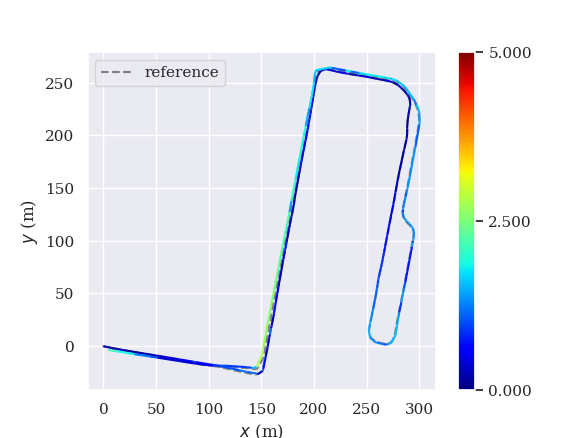

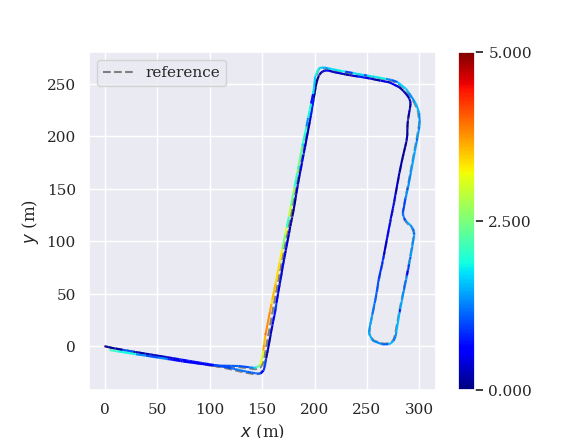

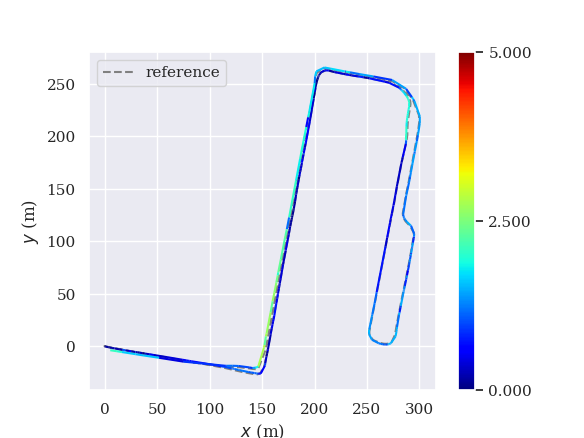

In [5]:
# Load data in local structure -> Deepcopy to avoid re-reading
data = deepcopy(DATA[route])
g_traj_ref = deepcopy(data[TestSets.OUTAGE_STRAIGHT][run]['GT_GPS'])
traj_est_1 = deepcopy(data[TestSets.WITH_KISS][run][est_trajectory_type])
traj_est_2 = deepcopy(data[TestSets.OUTAGE_STRAIGHT][run][est_trajectory_type])
traj_est_3 = deepcopy(data[TestSets.OUTAGE_TURN][run][est_trajectory_type])

trajectories = [traj_est_1, traj_est_2, traj_est_3]

# fig, _ = plt.subplots(3,1, figsize=get_figsize(wf=1, hf=1))


plot_idx = 311

for est in trajectories:
    fig = plt.figure(figsize=get_figsize(wf=1, hf=.75))
    traj_ref, traj_est = tum_tools.sync_trajectories(deepcopy(g_traj_ref), est, g_max_diff_ape)
    # reset traj_est z-coordinate to aling with traj_ref ==> No effect in pose error metric
    traj_est.positions_xyz[:,2] = traj_ref.positions_xyz[:,2]
    traj_est = PoseTrajectory3D(traj_est.positions_xyz, traj_est.orientations_quat_wxyz, traj_est.timestamps)
    
    ape_metric = metrics.APE(pose_relation=PoseRelation.translation_part)
    ape_metric.process_data((traj_ref, traj_est))
    
    ax = plot.prepare_axis(fig, PlotMode.xy)
    plot.traj(ax, PlotMode.xy, traj_ref, '--', "gray", "reference")
    plot.traj_colormap(ax, traj_est, ape_metric.error, 
                   PlotMode.xy, min_map=0, max_map=5, plot_start_end_markers=False)#, skip_cbar=True)
    
    fig_name = f"trajectory_{plot_idx}_.pdf"
    plt.savefig(path.join(result_figure_dir, fig_name), format="pdf", bbox_inches="tight")
    plot_idx +=1

In [ ]:
# Plot the segemnts
segment_size = 500
run=1

traj_ref = deepcopy(data[run]['GT_GPS'])
# traj_est = deepcopy(data[run][est_trajectory_type])
# aligned, _ = tum_tools.sync_trajectories(traj_ref, traj_ref, g_max_diff)

map = plot_trajectory_segments(traj_ref, n=segment_size, wf=1.5, hf=1.5)

## APE

In [ ]:
# plt.close('all')

pose_relations = [metrics.PoseRelation.translation_part] # , metrics.PoseRelation.rotation_angle_deg, metrics.PoseRelation.full_transformation]

traj_ref = deepcopy(data[run]["GT_GPS"])
traj_est = deepcopy(data[run][est_trajectory_type])

traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=g_max_diff_ape)

# reset traj_est z-coordinate to aling with traj_ref ==> No effect in pose error metric
traj_est.positions_xyz[:,2] = traj_ref.positions_xyz[:,2]
traj_est = PoseTrajectory3D(traj_est.positions_xyz, traj_est.orientations_quat_wxyz, traj_est.timestamps)

for pose_relation in pose_relations:
    ape_metric = metrics.APE(pose_relation=pose_relation)
    ape_metric.process_data((traj_ref, traj_est))
    # plot_statistical_error_metric(ape_metric, show_plot=False, save_dir=result_figure_dir, name_prefix=route)
    plot_statistical_error_metric(ape_metric, show_plot=False, save_dir="", name_prefix=route)


## RPE

In [6]:
plt.close('all')

delta = 1
all_pairs = False 
delta_unit = Unit.frames
data_set = data_set_01

pose_relations = [metrics.PoseRelation.translation_part]#, metrics.PoseRelation.rotation_angle_deg, metrics.PoseRelation.full_transformation]

traj_ref = deepcopy(data[run]["GT_GPS"])
traj_est = deepcopy(data[run][est_trajectory_type])
# traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=0.01)
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=0.01)

# reset traj_est z-coordinate to aling with traj_ref ==> No effect in pose error metric
traj_est.positions_xyz[:,2] = traj_ref.positions_xyz[:,2]
traj_est = PoseTrajectory3D(traj_est.positions_xyz, traj_est.orientations_quat_wxyz, traj_est.timestamps)

for pose_relation in pose_relations:
    rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
    rpe_metric.process_data((traj_ref, traj_est))
    plot_statistical_error_metric(rpe_metric, show_plot=False, save_dir=result_figure_dir, name_prefix=route)
    # plot_statistical_error_metric(rpe_metric, show_plot=False, save_dir="", name_prefix=route)
    rpe_results[f"{route}_{data_set}_{pose_relation.value}"] = rpe_metric.get_result()


# traj_ref_plot = deepcopy(traj_ref)
# traj_est_plot = deepcopy(traj_est)
# traj_ref_plot.reduce_to_ids(rpe_metric.delta_ids)
# traj_est_plot.reduce_to_ids(rpe_metric.delta_ids)
# seconds_from_start = [t - traj_est.timestamps[0] for t in traj_est.timestamps[1:]]


NameError: name 'data' is not defined

## Advanced Plots for direct comparison

In [7]:
def prepare_trajectory(diff, test_set):
    traj_ref = deepcopy(DATA[route][test_set][run]["GT_GPS"])
    traj_est = deepcopy(DATA[route][test_set][run]["EKF"])
    traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est, max_diff=diff)
    traj_est.positions_xyz[:,2] = traj_ref.positions_xyz[:,2]
    traj_est = PoseTrajectory3D(traj_est.positions_xyz, traj_est.orientations_quat_wxyz, traj_est.timestamps)
    return traj_ref, traj_est

In [8]:
# Compare RPE over sets: Advanced Plots...

pose_relation = metrics.PoseRelation.translation_part
run = 1
route= "mdv3_1"

for test_set in TestSets:
    
    test_name, _ = test_set.value

    traj_ref, traj_est = prepare_trajectory(g_max_diff_rpe, test_set)
    rpe_metric = metrics.RPE(pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, all_pairs=all_pairs)
    rpe_metric.process_data((traj_ref, traj_est))
    rpe_results[f"{route}_{test_name}_tranlsation"] = rpe_metric.get_result()
    

    traj_ref, traj_est = prepare_trajectory(g_max_diff_ape, test_set)
    ape_metric = metrics.APE(pose_relation=pose_relation)
    ape_metric.process_data((traj_ref, traj_est))
    ape_results[f"{route}_{test_name}_tranlsation"] = ape_metric.get_result()
    
    
    # ape_stats = ape_metric.get_all_statistics()
    # rpe_stats = rpe_metric.get_all_statistics()
    # print(f"{test_set.name}: APE: {ape_stats['mean']} & {ape_stats['max']} & {ape_stats['std']} & {ape_stats['rmse']}")
    # print(f"{test_set.name}: RPE: {rpe_stats['mean']} & {rpe_stats['max']} & {rpe_stats['std']} & {rpe_stats['rmse']}")
    
    
    

In [13]:
ape_results

{'mdv3_1_02_with_kiss_tranlsation': <evo.core.result.Result at 0x7fabc2eb2bb0>,
 'mdv3_1_04_straight_outage_tranlsation': <evo.core.result.Result at 0x7fabc2c8a760>,
 'mdv3_1_05_turn_outage_tranlsation': <evo.core.result.Result at 0x7fabc2eaa250>}

In [ ]:
# LINE CHART
plot_line_chart(ape_results, prefix=route)


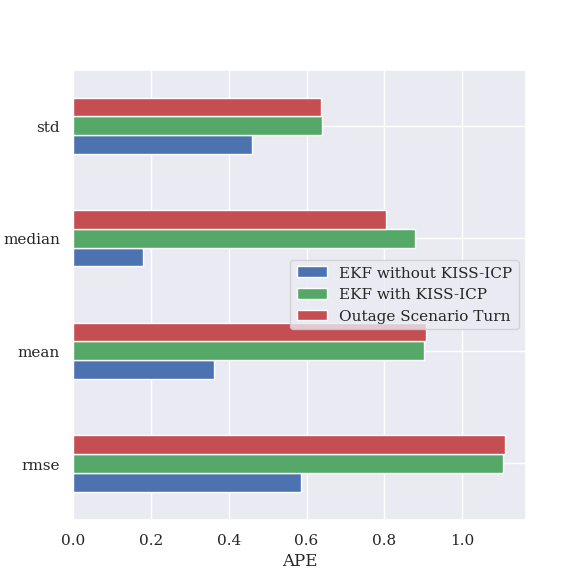

In [9]:
# BOX CHART
# plot_boxchart(rpe_results,"RPE")
plot_boxchart(ape_results, xlabel="APE", prefix=route)

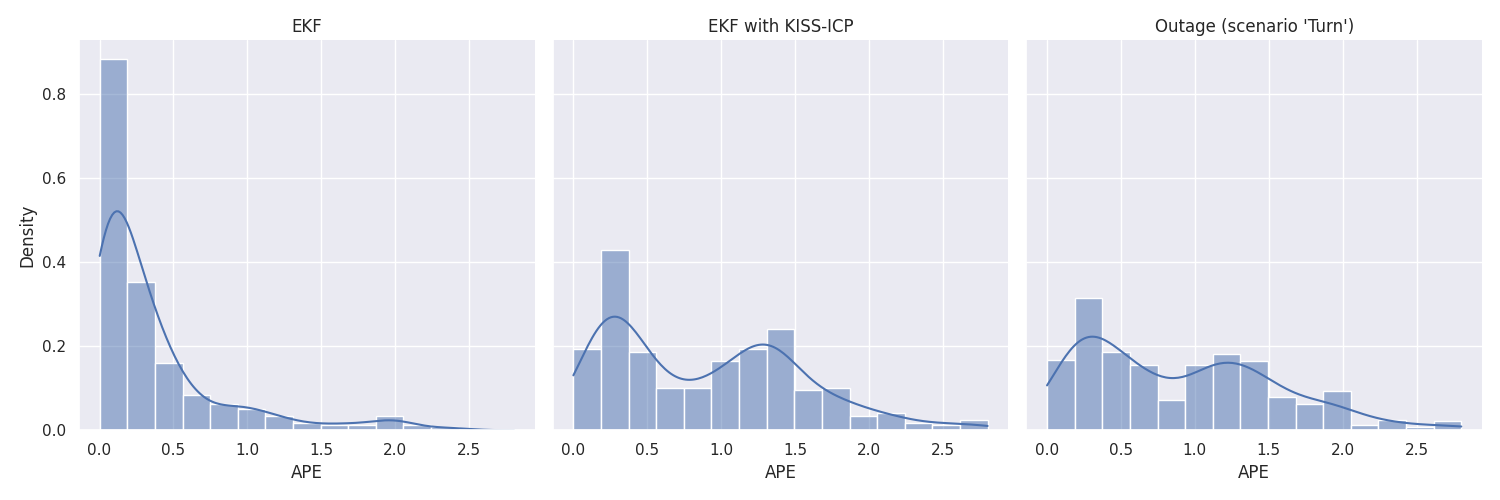

In [77]:
plt.close('all')
# plot_boxplot(ape_results, prefix=route, label="APE")
# plot_violin(ape_results, prefix=route, label="APE")
plot_hist(ape_results, prefix=route, label="APE")

# plot_ecdf(ape_results, prefix=route, label="APE")
# plt.savefig(path.join(result_figure_dir, "violin_plot.pdf"), format="pdf", bbox_inches="tight")
# plt.savefig(path.join(result_figure_dir, "ECDF_plot.pdf"), format="pdf", bbox_inches="tight")